In [ ]:
#Crear las carpetas para subir las imagenes

!mkdir basket # creo carpeta de basket
!mkdir futbol # creo carpeta de futbol
!mkdir tennis # creo carpeta de tennis

In [ ]:
!pip install pyunpack
!pip install patool

# Agrego archivos .rar con muchas imagenes que extraje de google usando una extensión llamada "Download All Images" de mobilefirst, descartando los resultados que no sirven, como cuando me aparece una pelota de golf en la búsqueda de pelotas de tennis

from pyunpack import Archive # importo una librería para extraer archivos .rar
Archive('/content/basket/basket.rar').extractall('/content/basket/') # el primer path es la ubicación del archivo .rar que agregué manualmente con las imagenes y el segundo es donde lo quiero extraer (la misma carpeta)
Archive('/content/futbol/futbol.rar').extractall('/content/futbol/')
Archive('/content/tennis/tennis.rar').extractall('/content/tennis/')

In [ ]:
# Elimino los archivos .rar con las imagenes porque ya no me hacen falta al estar extraidas en la carpeta
!rm -rf /content/basket/basket.rar
!rm -rf /content/futbol/futbol.rar
!rm -rf /content/tennis/tennis.rar

In [ ]:
# Me fijo cuantas imagenes tengo de cada categoria
!ls /content/basket | wc -l # 313
!ls /content/futbol | wc -l # 356
!ls /content/tennis | wc -l # 235

313
356
235


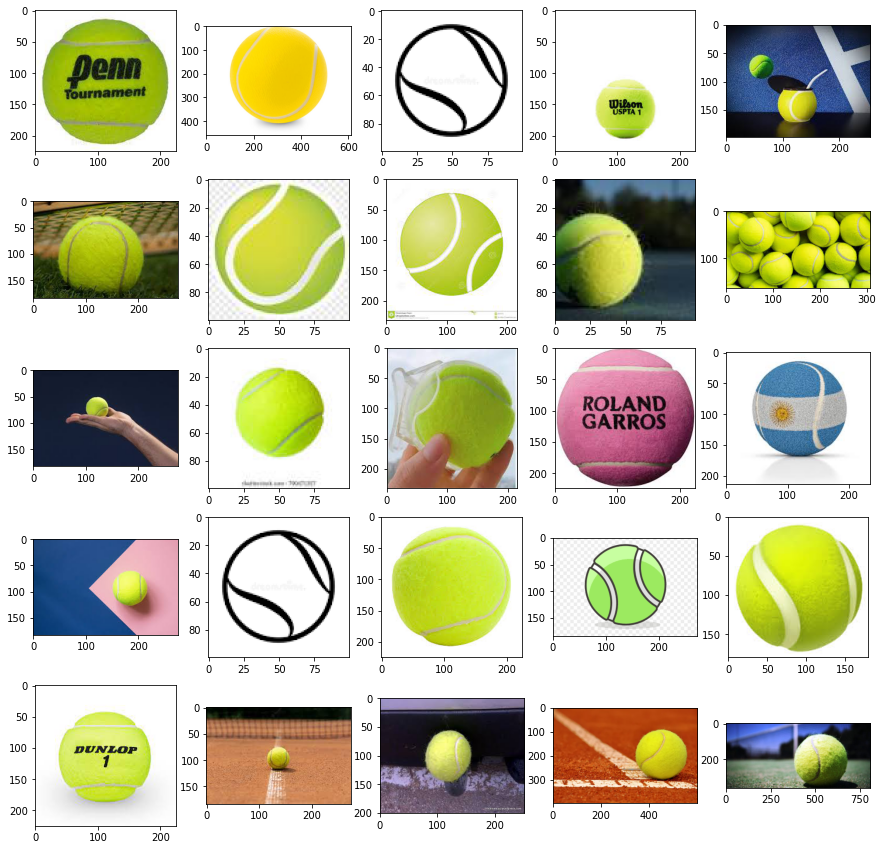

In [ ]:
# Chequeo con pyplot que se vean bien las imagenes
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15)) 

carpeta = '/content/tennis' # pruebo con las de tennis
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]): # filtro por las primeras 25 imgs
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg) # formateo todo para que me deje ver la imagen
  plt.imshow(imagen) # muestra imagen

In [ ]:
# Creo carpetas para hacer el ds (dataset)

!mkdir dataset # uno general para meter cada ds individualmente como otra carpeta
!mkdir dataset/ds_basket
!mkdir dataset/ds_futbol
!mkdir dataset/ds_tennis

In [ ]:
# Copio las imagenes a cada ds

# Primero con Basket

min_imgs = 235 # menor numero de imagenes que hay entre las 3 carpetas de archivos

import shutil
carpeta_fuente = '/content/basket'
carpeta_destino = '/content/dataset/ds_basket'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < min_imgs:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [ ]:
# Segundo con Futbol

carpeta_fuente = '/content/futbol'
carpeta_destino = '/content/dataset/ds_futbol'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < min_imgs:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [ ]:
# Tercero y último con tennis

carpeta_fuente = '/content/tennis'
carpeta_destino = '/content/dataset/ds_tennis'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < min_imgs:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [ ]:
# Me fijo cuantas imagenes hay en cada ds
!ls /content/dataset/ds_basket | wc -l
!ls /content/dataset/ds_futbol | wc -l
!ls /content/dataset/ds_tennis | wc -l

241
235
235


Found 554 images belonging to 3 classes.
Found 137 images belonging to 3 classes.


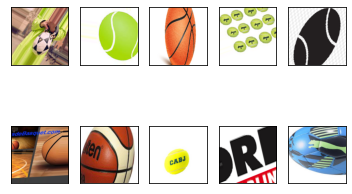

In [ ]:
# Aumento de datos (dado que mi modelo es muy pequeño) con ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
import numpy as np

# Genero el dataset
datagen = ImageDataGenerator(
    rescale= 1. / 255, # cambia el tamaño
    rotation_range = 30, # rota la imagen
    width_shift_range = 0.25, # varía el ancho
    height_shift_range = 0.25, # varía la altura
    shear_range = 15, # cambia la imagen para que se vea como un paralelogramo 
    zoom_range = [0.5, 1.5], # zoomea la imagen aleatoriamente
    validation_split=0.2 # 20% para pruebas
)
# Estas se emparejaron (con pequeñas modificaciones a imagenes ya existentes como rotarlas o resizearlas, ya explique que hace cada una) para que sean más o menos la misma cantidad y todas sean útiles para el entrenamiento


# Genero sets para entrenarlos y luego para testear el modelo entrenado
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training') # agarro 32 imagenes del dataset general (pueden ser de los 3 tipos de pelotas) de 224x224 aleatorizadas para 

data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

# Imprimo con pyplot 10 imagenes que se van a usar para el entrenamiento para chequear que esté todo bien
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # Importo un modelo a través de tf_hub con las capas iniciales dado que están estandarizadas para que me sirvan sin importar que imagenes quiera usar
                                                                           # y después le agrego una última capa para adaptarlo a mi ds
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [ ]:
# Congelo el modelo importado para que no toquen esas capas sino solo la últimas que es la que modifica las imagenes 
mobilenetv2.trainable = False

In [ ]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(3, activation='softmax') # Agrego una última capa con 3 outputs, y una función de activación Softmax
])

In [ ]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Compilo el modelo
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # muestro que tanto se equivocó 
    metrics=['accuracy'] # muestro la precisión (1 perfecto, 0 erró todo)
)

In [ ]:
# Entreno el modelo
EPOCAS = 50 # 50 epochs, de 32 batches, en cada epoch se prueba una imagen de entrada, se la procesa en las capas, y se revisa que tan cerca estuvo el resultado del que debería ser, dependiendo de que tan bien les haya ido modifican las neuronas

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32, # se agarran los datos de entrenamiento
    validation_data=data_gen_pruebas                      # se comparan con los que deberían ser
)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.9156 - accuracy: 0.6155

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


18/18 [==============================] - 35s 2s/step - loss: 0.9156 - accuracy: 0.6155 - val_loss: 0.3538 - val_accuracy: 0.9416
Epoch 2/50
18/18 [==============================] - 29s 2s/step - loss: 0.3614 - accuracy: 0.8917 - val_loss: 0.1663 - val_accuracy: 0.9635
Epoch 3/50
18/18 [==============================] - 30s 2s/step - loss: 0.2528 - accuracy: 0.9206 - val_loss: 0.1657 - val_accuracy: 0.9270
Epoch 4/50
18/18 [==============================] - 31s 2s/step - loss: 0.2126 - accuracy: 0.9242 - val_loss: 0.1473 - val_accuracy: 0.9343
Epoch 5/50
18/18 [==============================] - 29s 2s/step - loss: 0.1937 - accuracy: 0.9242 - val_loss: 0.1403 - val_accuracy: 0.9562
Epoch 6/50
18/18 [==============================] - 31s 2s/step - loss: 0.1720 - accuracy: 0.9549 - val_loss: 0.0848 - val_accuracy: 0.9781
Epoch 7/50
18/18 [==============================] - 31s 2s/step - loss: 0.1692 - accuracy: 0.9567 - val_loss: 0.1304 - val_accuracy: 0.9416
Epoch 8/50
18/18 [=============

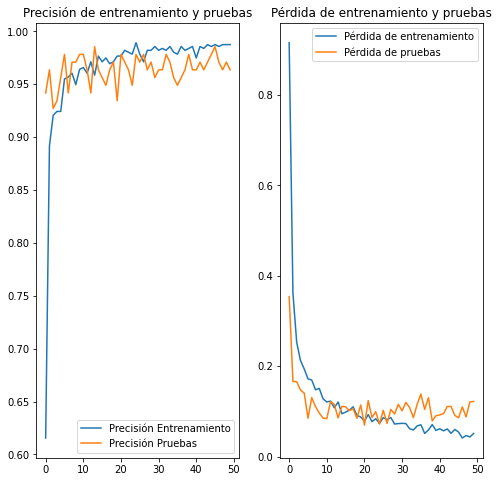

In [ ]:
# Grafico el progreso durante el entrenamiento
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [ ]:
# Creo una funcion para leer las imagenes de internet y testearlas con la IA 
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url) # recibo imagen
  img = Image.open(BytesIO(respuesta.content)) # abro la imagen
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224)) # la rescalo para que sea del tamaño que usa mi IA
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3)) # uso el método predict con la imagen de las mismas caracterísitcas de las que use para entrenar
  return np.argmax(prediccion[0], axis=-1)


![Pelota de testing](https://thumbs.dreamstime.com/b/bola-del-baloncesto-sobre-el-fondo-blanco-80382875.jpg)

In [ ]:
#0 = basket, 1 = futbol, 2 = tennis
url = 'https://thumbs.dreamstime.com/b/bola-del-baloncesto-sobre-el-fondo-blanco-80382875.jpg' # agarro una imagen de una pelota de basket de internet
prediccion = categorizar(url) # corro el método
print(prediccion) #podemos ver que es 0, ya que es una pelota de basket 

1/1 [==============================] - 1s 727ms/step
0
